# 1. Introduction

## Turbulent Flow Data Analysis

This notebook is dedicated to analyzing flow data from CFD simulations stored in PVTU format. Our focus will be on calculating various statistical measures that describe the flow characteristics. These include:

- Mean velocity component \( u \) averaged over \( x \), \( z \), and time \( t \) as a function of \( y \).
- The Reynolds shear stress component \( -u'v' \) averaged similarly.
- RMS fluctuations for velocity components \( u \) and \( v \), also averaged over \( x \), \( z \), and time \( t \).



# 2. Importation of Useful Libraries

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import scipy.stats as stats

print("Libraries imported successfully.")

Libraries imported successfully.


# 3. Data Loading

## Data Loading

In this section, we load the CFD simulation data from PVTU files located in a specified directory. Each file represents a snapshot of the flow at different times, allowing us to perform temporal and spatial analyses.

In [193]:
def load_data(directory):
    files = [f for f in os.listdir(directory) if f.endswith('.pvtu')]
    data_frames = []
    for file in files:
        path = os.path.join(directory, file)
        data = pv.read(path)
        if 'VELOC' in data.point_data:
            veloc_data = data.point_data['VELOC']
            df = pd.DataFrame({
                'x': data.points[:, 0],
                'y': data.points[:, 1],
                'z': data.points[:, 2],
                'u': veloc_data[:, 0],
                'v': veloc_data[:, 1],
                'w': veloc_data[:, 2]
            })
            data_frames.append(df)
    all_data = pd.concat(data_frames, ignore_index=True)
    print(f"Loaded data from {len(files)} files.")
    return all_data

# Set the directory path where your PVTU files are stored
directory_path = 'vtk'
all_data = load_data(directory_path)

Loaded data from 40 files.


# 4. Normalization 

We aim to validate our code by comparing our results with those of Jiménez. To ensure consistency, we will adopt the same normalization method used in their study. 

In the simulations of minimal channel turbulence, the paper employs a density of $ \rho = 1 $ and a kinematic viscosity of $ \nu = 0.01 $. 


## Definitions 
### Velocity flucation 
The velocity flucation is defined as the difference between the instantaneous velocity ($u$) and the mean over time velocity ($\bar{u}$):

$$ u' = u - \bar{u} $$

### Root mean squarevelocity 
The root mean square (RMS) velocity ($u_{\text{RMS}}$) is defined as the square root of the time-averaged square of the fluctuating velocity ($u'$):

$$ u_{\text{RMS}} = \sqrt{\overline{{u'}^2}} $$

When expressing $u_{\text{RMS}}(y)$ instead of $u_{\text{RMS}}(x,y,z)$, it signifies averaging over the $x$ and $z$ dimensions.

### Wall Shear Stress 
The spatially avergaed instantaneous wall shears is define as follow (integrated over $x$ and $z$):
$$ \Omega(y=\pm 1) = \frac{1}{\lambda_x \lambda_z} \int_{0}^{\lambda_x} \int_{0}^{\lambda_z} \frac{\partial u}{\partial y} \bigg|_{\left(x, \pm 1, z\right)} \, dx \, dz.
 $$

### Time-Averaged Wall Shears 
The local friction velocities is written: 
$$u_{\tau}(y=\pm 1)=(\overline{\Omega(y=\pm 1)}_{\tau}\nu)^{1/2}$$

### Non-Dimensional Wall Units and Velocity Units
In subsequent discussions, $u_{\tau}=u_{\tau}(y=-1)$ will be used, indicating evaluation at $y=-1$.
To analyze the flow in wall units, distances and velocities are non-dimensionalized using the viscous length scale and friction velocity:

$$
y^+ = \frac{y }{\nu}, \quad u^+ = \frac{u}{u_{\tau}},
$$

where $y$ is the normal distance from the wall, and $u$ is the local flow velocity.

## Normalization Calculation directly with time averaged

Let's now calculate $u_{\tau}$ to normalize our data. Firstly, we compute $\Omega$, selecting the top wall which is indexed as 2 in our code.

**Note :**
In our code, $y$ ranges from 0 to 2, whereas in the definition, it ranges from -1 to 1. The results remain consistent; we simply need to exercise caution.

In [194]:
def compute_domain_sizes(data):
    lambda_x = data['x'].max() - data['x'].min()
    lambda_z = data['z'].max() - data['z'].min()
    return lambda_x, lambda_z

def compute_omega(data, lambda_x, lambda_z, y_near_wall):
    # Filter data for near the wall, not exactly at y = 2
    wall_data = data[(data['y'] > y_near_wall) & (data['y'] < 2)]
    
    # Group by x and z to calculate partial derivatives
    if wall_data.empty:
        raise ValueError("No data points near the wall for the specified y range.")
    
    # Ensure there are enough points in each group (by 'x' and 'z') to compute the gradient
    if wall_data.groupby(['x', 'z']).size().min() < 2:
        raise ValueError("Not enough data points in each (x, z) group to calculate gradient.")
    
    # Group data by 'x' and 'z' and calculate the gradient of 'u' with respect to these groups
    derivs = wall_data.groupby(['x', 'z'])['u'].apply(lambda u: np.gradient(u, edge_order=2)[0] if len(u) > 0 else np.nan)

    # Convert the Series of gradients into a DataFrame
    deriv_df = derivs.reset_index()
    deriv_df.columns = ['x', 'z', 'du_dy']

    # Calculate the mean of the derivative over all 'x' and 'z' to get an integrated value
    integrated_dudy = np.nanmean(deriv_df['du_dy'])

    # Compute Omega using the domain dimensions
    omega = integrated_dudy / (lambda_x * lambda_z)
    return omega

# Usage
lambda_x, lambda_z = compute_domain_sizes(all_data)
y_near_wall = 1.9  # adjust this value based on your grid and where data is non-zero
try:
    omega = compute_omega(all_data, lambda_x, lambda_z, y_near_wall)
    print("Domain sizes - Lambda_x:", lambda_x, "Lambda_z:", lambda_z)
    print("Omega:", omega)
except ValueError as e:
    print(str(e))



Domain sizes - Lambda_x: 2.67 Lambda_z: 0.8
Omega: 0.002762836411143807


In [195]:
viscosity = 0.0003546986585888876*1000 # the one in our programme
# Compute the friction velocity u_tau using the time-averaged Omega and the viscosity
u_tau = (omega * viscosity)**0.5
print("Friction velocity u_tau:", u_tau)

Friction velocity u_tau: 0.03130454230512315


## Normalizing Velocity Components

Once the friction velocity $u_{\tau}$ is calculated, velocity components can be normalized. This process involves dividing the actual velocity values by $u_{\tau}$ to convert them into wall units, denoted as $u^+$ for the streamwise component and $v^+$ for the spanwise component. This non-dimensionalization is essential for analyzing flow characteristics close to the wall.

### Code Cell: Apply Normalization and Analyze

In [196]:
# Assuming 'all_data' is a DataFrame containing the velocity components 'u' and 'v'
all_data['u_non_normalise'] = all_data['u'] 
all_data['v_non_normalise'] = all_data['v'] 
all_data['w_non_normalise'] = all_data['w'] 

all_data['u'] = all_data['u_non_normalise'] / u_tau
all_data['v'] = all_data['v_non_normalise'] / u_tau
all_data['w'] = all_data['w_non_normalise'] / u_tau

# Writting like this to save non normalise values + having u and v normalise 

# 5. Calculation of Statistics

## Calculation of Statistics

Now we calculate the required statistics to analyze the flow data. We will compute:
- Mean \( u \) as a function of \( y \).
- Reynolds shear stress \( -u'v' \).
- RMS fluctuations for \( u \) and \( v \).

**Code Cell for Mean Calculation:**

In [197]:
def calculate_mean_u(data):
    return data.groupby('y')['u'].mean()

mean_u = calculate_mean_u(all_data)

**Code Cell for Shear Stress Calculation:**

In [198]:
def calculate_shear_stress(data):
    grouped = data.groupby('y')
    shear_stress = grouped.apply(lambda df: -np.mean((df['u'] - df['u'].mean()) * (df['v'] - df['v'].mean())), include_groups=False)
    return shear_stress

shear_stress = calculate_shear_stress(all_data)


**Code Cell for RMS Fluctuations:**

In [199]:
def calculate_rms_fluctuations(data):
    grouped = data.groupby('y')
    u_rms = grouped['u'].apply(lambda u: np.sqrt(np.mean((u - u.mean())**2)))
    v_rms = grouped['v'].apply(lambda v: np.sqrt(np.mean((v - v.mean())**2)))
    w_rms = grouped['w'].apply(lambda w: np.sqrt(np.mean((w - w.mean())**2)))
    return u_rms, v_rms, w_rms

u_rms, v_rms, w_rms = calculate_rms_fluctuations(all_data)

# 6. Plotting Results

## Plotting Results

Visualize the computed statistics to better understand the flow dynamics and turbulence characteristics.

**Code Cell for Plotting:**

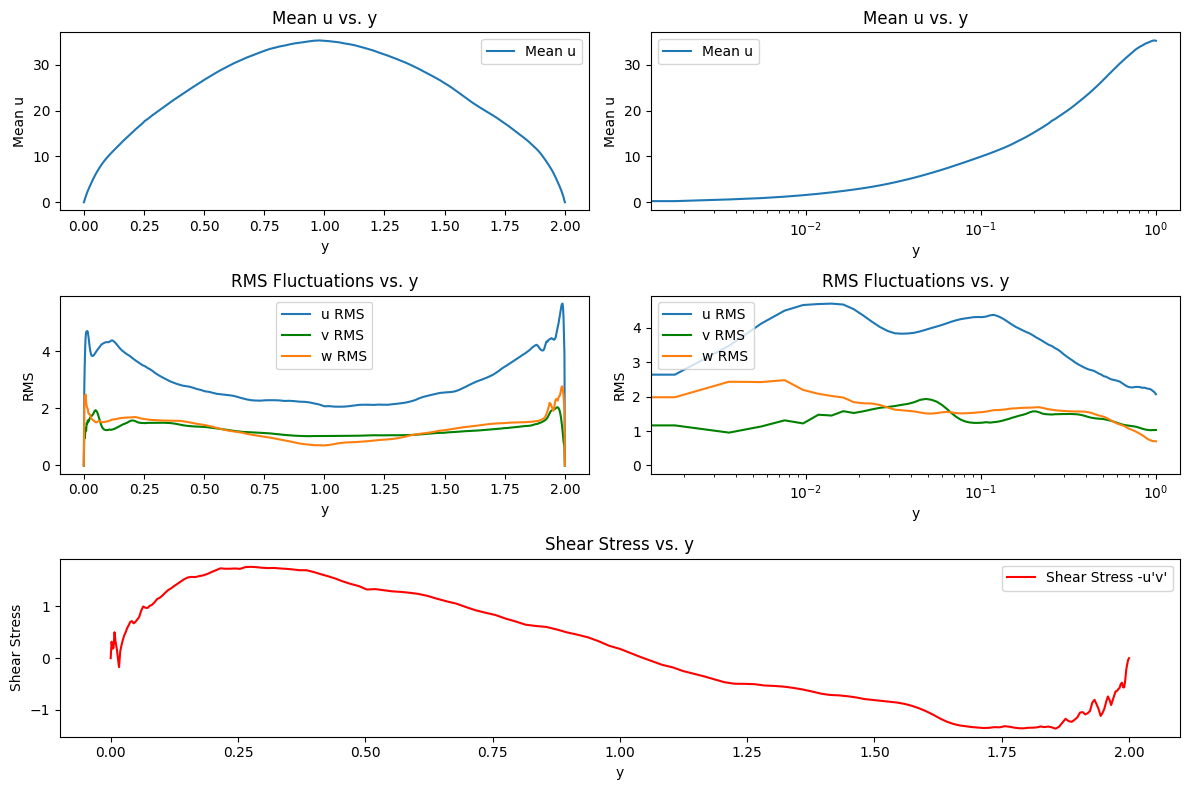

In [184]:
plt.figure(figsize=(12, 8))
plt.subplot(321)
plt.plot(mean_u.index, mean_u, label='Mean u')
plt.title('Mean u vs. y')
plt.xlabel('y')
plt.ylabel('Mean u')
plt.legend()

mean_u_filtered = mean_u[(mean_u.index >= 0) & (mean_u.index <= 1)]
plt.subplot(322)
plt.plot(mean_u_filtered.index, mean_u_filtered, label='Mean u')
plt.xscale('log')
plt.title('Mean u vs. y')
plt.xlabel('y')
plt.ylabel('Mean u')
plt.legend()

plt.subplot(323)
plt.plot(u_rms.index, u_rms, label='u RMS')
plt.plot(v_rms.index, v_rms, label='v RMS', color='green')
plt.plot(w_rms.index, w_rms, label='w RMS')
plt.title('RMS Fluctuations vs. y')
plt.xlabel('y')
plt.ylabel('RMS')
plt.legend()

u_rms_filtered = u_rms[(u_rms.index >= 0) & (u_rms.index <= 1)]
v_rms_filtered = v_rms[(v_rms.index >= 0) & (v_rms.index <= 1)]
w_rms_filtered = w_rms[(w_rms.index >= 0) & (w_rms.index <= 1)]
plt.subplot(324)
plt.plot(u_rms_filtered.index, u_rms_filtered, label='u RMS')
plt.plot(v_rms_filtered.index, v_rms_filtered, label='v RMS', color='green')
plt.plot(w_rms_filtered.index, w_rms_filtered, label='w RMS')
plt.xscale('log')
plt.title('RMS Fluctuations vs. y')
plt.xlabel('y')
plt.ylabel('RMS')
plt.legend()


plt.subplot(313)
plt.plot(shear_stress.index, shear_stress, color='red', label='Shear Stress -u\'v\'')
plt.title('Shear Stress vs. y')
plt.xlabel('y')
plt.ylabel('Shear Stress')
plt.legend()

plt.tight_layout()
plt.show()

# Test to understand time 

In [201]:
import os
import pyvista as pv
import pandas as pd

def load_data(directory):
    files = [f for f in os.listdir(directory) if f.endswith('.pvtu')]
    data_frames = []
    for file in files:
        time_step = float(file.split('_')[-1].rstrip('s.pvtu'))  # Extracting time from filename
        path = os.path.join(directory, file)
        data = pv.read(path)
        if 'VELOC' in data.point_data:
            veloc_data = data.point_data['VELOC']
            df = pd.DataFrame({
                'time': time_step,
                'x': data.points[:, 0],
                'y': data.points[:, 1],
                'z': data.points[:, 2],
                'u': veloc_data[:, 0],
                'v': veloc_data[:, 1],
                'w': veloc_data[:, 2]
            })
            data_frames.append(df)
    all_data = pd.concat(data_frames, ignore_index=True)
    print(f"Loaded data from {len(files)} files.")
    return all_data

# Set the directory path where your PVTU files are stored
directory_path = 'vtk'
all_data = load_data(directory_path)


Loaded data from 40 files.


In [202]:
all_data

,time,x,y,z,u,v,w
0,800.0,0.611875,0.198044,0.383333,0.391545,-0.049320,0.001854
1,800.0,0.611875,0.181479,0.383333,0.376823,-0.060914,-0.004633
2,800.0,0.611875,0.198044,0.316667,0.382288,-0.020805,0.030915
3,800.0,0.611875,0.181479,0.316667,0.355270,-0.030127,0.017322
4,800.0,0.389375,0.198044,0.383333,0.361041,-0.016048,0.009015
...,...,...,...,...,...,...,...
19566915,2900.0,1.335000,0.254154,0.716667,0.611768,-0.068302,-0.001272
19566916,2900.0,1.335000,0.254154,0.733333,0.612505,-0.064904,0.000276
19566917,2900.0,1.335000,0.254154,0.750000,0.614702,-0.064535,0.004109
19566918,2900.0,1.335000,0.254154,0.766667,0.620510,-0.067120,0.010342


A faire : mieux comprendre ce que je peux extraire de veloc_data, potentiellement demnadande à Pol 